In [106]:
import nbsetup
import pymc3 as pm
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from models.sparc.result import Result

In [107]:
default = Result()

In [151]:
df = default.datasets()['Quality Thresholded']

In [173]:
coords = {
    "Galaxy": df.ID.unique(),
    "Observation": df.Vobs.index
}

# using the ref values as the initial reference points
reference = df.groupby('ID').mean()[['Inc', 'e_Inc', 'D', 'e_D']]#+['Ydisk','e_Ydisk','Ybul','e_Ybul']

# for g param
if 'gidx' not in df.columns:
    uniqs = df.ID.unique()
    indx = pd.DataFrame({'ID':uniqs, 'gidx':np.arange(len(uniqs))})
    df = df.join(indx.set_index('ID'), on='ID')

with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 200)
    alpha = pm.Uniform('alpha', 0, 1)
    
    # Galaxy priors
    # As per method of RAR papera
    DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
    inc = DegreesNormal('Inc', mu=reference.Inc, sigma=reference.e_Inc, dims='Galaxy')
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    dist = PositiveNormal('D', mu=reference.D, sigma=reference.e_D, dims='Galaxy')
    #Ydisk = PositiveNormal('Ydisk', mu=reference.Ydisk, sigma=reference.e_Ydisk, dims='Galaxy')
    #Ybul = PositiveNormal('Ybul', mu=reference.Ybul, sigma=reference.e_Ybul, dims='Galaxy')
    #if use_tau: tau = pm.Exponential('tau', 1)
    tau = 0

    # Data
    force = pm.Data("force", df.Fnewton, dims="Observation")
    radius = pm.Data("radius", df.R, dims="Observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="Observation")
    sparc_d = pm.Data("sparc_distance", df.D, dims="Observation")
    sparc_inc = pm.Data("sparc_inc", df.Inc, dims="Observation")
    g = pm.Data("g", df.gidx, dims="Observation")
    
    # Prediction model
    # adjust for nulled field
    ftd = force*(gamma/(1+(nulled)**alpha))
    # adjust r for distance when calc V
    vtd = np.sqrt(ftd*radius*dist[g]/sparc_d[g])
    # adjust the predicition for inclination of Vobs
    Vpred = vtd*np.sin(inc[g]*np.pi/180)/np.sin(sparc_inc[g]*np.pi/180)
    
    # Define likelihood
    obs = pm.Normal("obs", mu=Vpred, sigma=df.e_Vobs, observed=df.Vobs, dims="Observation")

In [174]:
with galaxy_model:
    start = pm.find_MAP()
    print(start['gamma'], start['alpha'])
    trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, target_accept=0.9, start=start)


94.59015055428985 0.25253932477916075


/var/folders/xp/fglbvhls6671ywk1lqtr308w0000gn/T/ipykernel_61772/1952488712.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, target_accept=0.9, start=start)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D, Inc, alpha, gamma]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 425 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'alpha'}>], dtype=object)

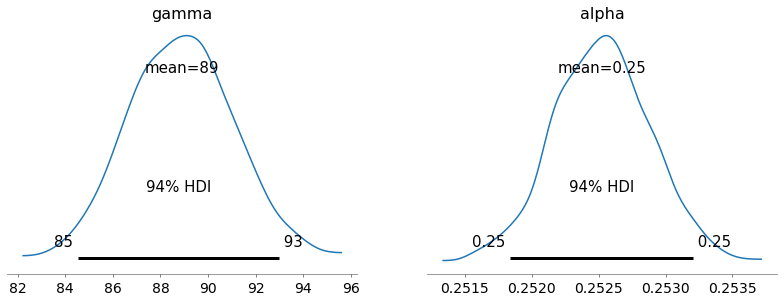

In [176]:
az.plot_posterior(trace, var_names=['gamma', 'alpha'])

array([[<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'Inc\nCamB'}>,
        <AxesSubplot:title={'center':'Inc\nDDO064'}>],
       [<AxesSubplot:title={'center':'Inc\nDDO154'}>,
        <AxesSubplot:title={'center':'Inc\nDDO161'}>,
        <AxesSubplot:title={'center':'Inc\nDDO168'}>,
        <AxesSubplot:title={'center':'Inc\nDDO170'}>],
       [<AxesSubplot:title={'center':'Inc\nESO079-G014'}>,
        <AxesSubplot:title={'center':'Inc\nESO116-G012'}>,
        <AxesSubplot:title={'center':'Inc\nESO444-G084'}>,
        <AxesSubplot:title={'center':'Inc\nF563-1'}>],
       [<AxesSubplot:title={'center':'Inc\nF563-V2'}>,
        <AxesSubplot:title={'center':'Inc\nF565-V2'}>,
        <AxesSubplot:title={'center':'Inc\nF568-1'}>,
        <AxesSubplot:title={'center':'Inc\nF568-3'}>],
       [<AxesSubplot:title={'center':'Inc\nF568-V1'}>,
        <AxesSubplot:title={'center':'Inc\nF571-V1'}>,
        <AxesSubplo

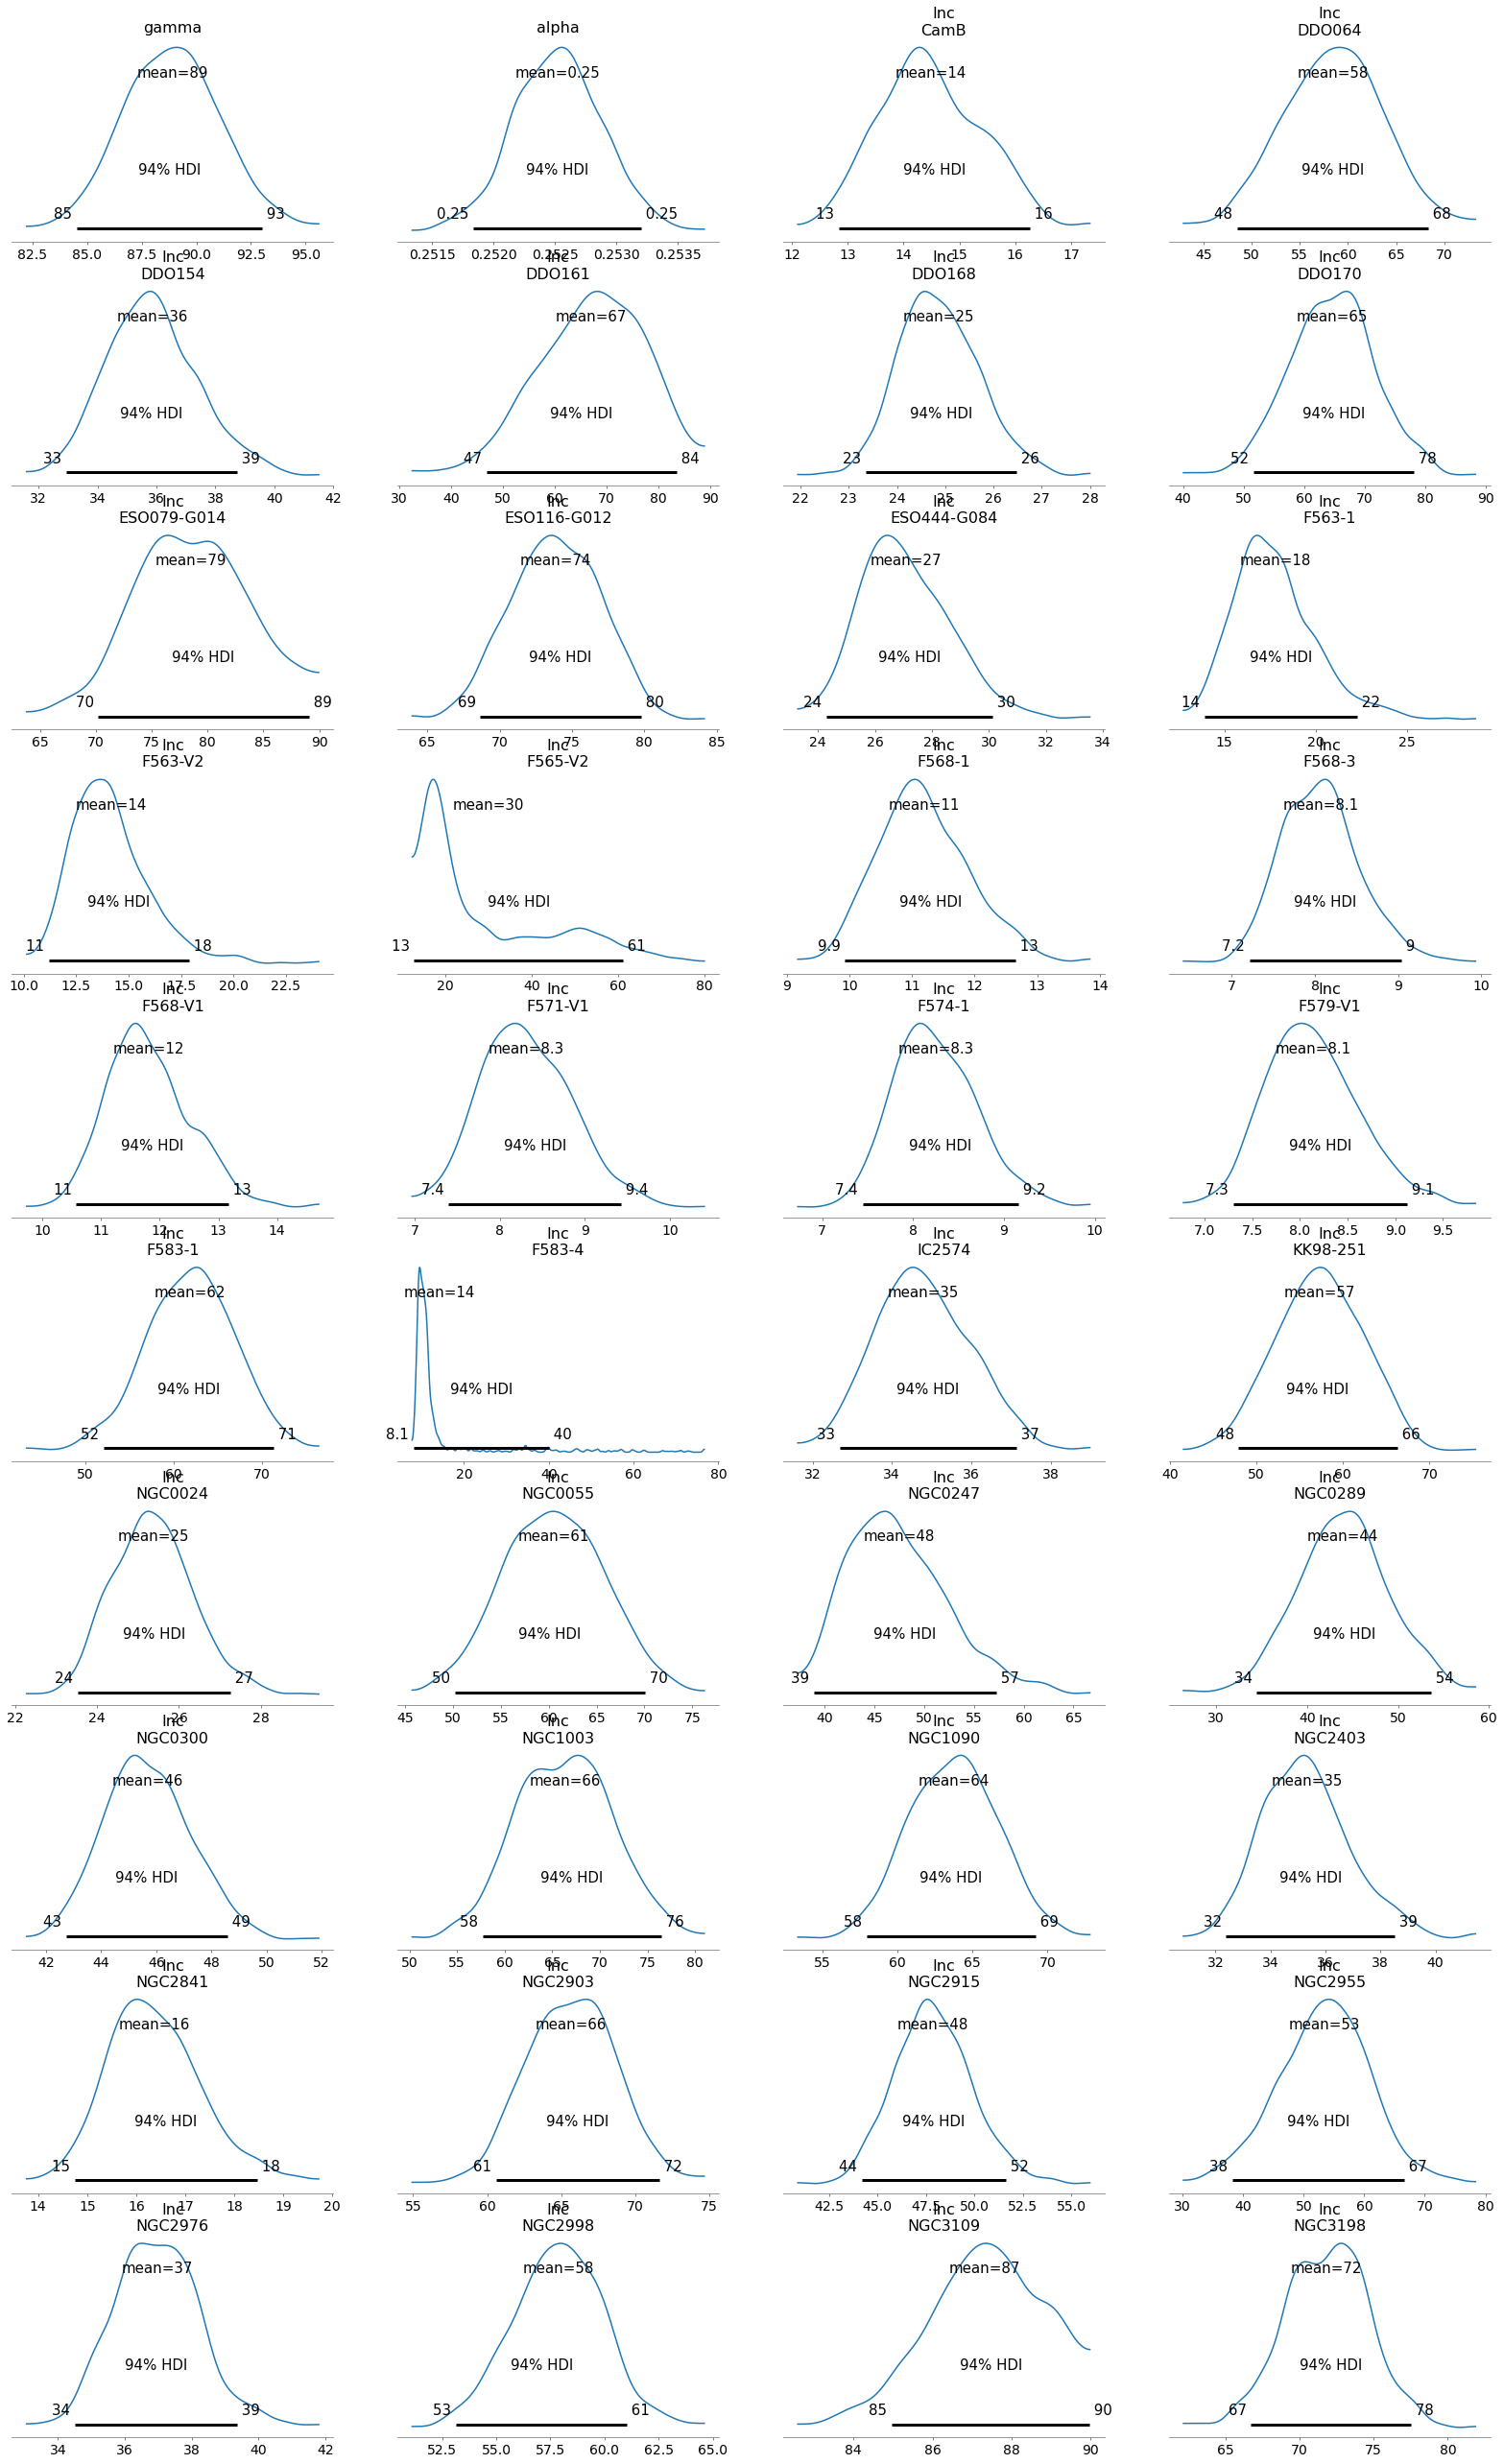

In [181]:
az.plot_posterior(trace)

In [184]:
az.summary(trace, fmt='long')

,galaxy,gamma,alpha,Inc,D
mean,CamB,88.89,0.253,14.492,3.002
mean,DDO064,88.89,0.253,58.462,1.165
mean,DDO154,88.89,0.253,35.852,3.223
mean,DDO161,88.89,0.253,67.078,0.559
mean,DDO168,88.89,0.253,24.871,4.096
...,...,...,...,...,...
r_hat,UGC11914,1.02,1.008,1.003,1.003
r_hat,UGC12632,1.02,1.008,1.004,1.003
r_hat,UGC12732,1.02,1.008,1.000,1.000
r_hat,UGCA442,1.02,1.008,1.007,1.006


In [182]:
help(az.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Optional[List[str]] = None, filter_vars=None, group=None, fmt: "Literal['wide', 'long', 'xarray']" = 'wide', kind: "Literal['all', 'stats', 'diagnostics']" = 'all', round_to=None, circ_var_names=None, stat_funcs=None, extend=True, hdi_prob=None, skipna=False, labeller=None, coords=None, index_origin=None, order=None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data: obj
        Any object that can be converted to an :class:`arviz.InferenceData` object
        Refer to documentation of :func:`arviz.convert_to_dataset` for details
    var_names: list
        Names of variables to include in summary. Prefix the variables by ``~`` when you
        want to exclude them from the summary: `["~beta"]` instead of `["beta"]` (see
        examples below).
    filter_vars: {None, "like", "regex"}, optional, de

In [177]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
gamma,88.890,2.262,84.517,93.000
alpha,0.253,0.000,0.252,0.253
Inc[CamB],14.492,0.945,12.844,16.259
Inc[DDO064],58.462,5.353,48.473,68.305
Inc[DDO154],35.852,1.548,32.927,38.752
...,...,...,...,...
D[UGC11914],10.624,3.665,4.753,17.640
D[UGC12632],6.249,0.708,4.941,7.522
D[UGC12732],11.213,2.635,6.645,15.989
D[UGCA442],4.255,0.220,3.844,4.641


In [170]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
gamma,36.048,2.414,31.832,38.924
alpha,0.248,0.001,0.247,0.249
sigma[0],6.595,6.789,0.876,17.770
sigma[1],14.532,9.901,4.586,31.196
sigma[2],30.774,29.526,4.536,89.208
...,...,...,...,...
D[UGC11914],17.940,3.696,11.615,24.992
D[UGC12632],12.466,1.251,10.138,14.785
D[UGC12732],18.525,2.849,13.623,24.470
D[UGCA442],4.599,0.224,4.235,5.009


In [157]:
posteriordd

{'obs': array([[ 24.78610035,  24.99635895, -10.97119903, ...,  21.41208904,
          16.16998118,  10.43090307],
        [ 24.48056763,  71.46405252,  40.80191336, ...,  27.84226285,
          22.85789973,  23.45858517],
        [ 13.15052996,  58.50964373,  39.08325857, ...,  18.01796191,
          24.62806529,  33.06770232],
        ...,
        [ 54.60549942, 212.98418701,  71.76947305, ...,  22.40002107,
          32.16152016,  21.08218916],
        [ 33.72881149,   4.90726533,  10.07486709, ...,  27.86851754,
         -12.48300182,  30.38161369],
        [111.33101287,  57.8094627 ,  64.81452545, ...,  12.98646594,
          11.67379505,  12.62532263]])}

In [145]:
gamma.trace()

ValueError: ('ExtractDiag needs an input with 2 or more dimensions', gamma ~ Uniform)

In [137]:
az.summary(gal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,99.233,0.691,97.936,99.996,0.070,0.050,102.0,128.0,1.02
alpha,0.263,0.002,0.259,0.266,0.000,0.000,25.0,46.0,1.09
sigma[1],30.258,47.265,6.628,60.747,4.483,3.178,194.0,156.0,1.02
sigma[2],35.848,31.521,8.425,91.642,2.485,1.760,161.0,150.0,1.01
sigma[3],57.774,117.712,8.489,136.423,9.476,6.713,150.0,153.0,1.00
...,...,...,...,...,...,...,...,...,...
D[UGC12632],20.450,1.816,17.266,23.799,0.233,0.169,66.0,118.0,1.03
D[UGC12732],26.350,2.205,21.991,30.229,0.178,0.127,156.0,226.0,1.03
D[UGCA281],5.783,0.247,5.358,6.264,0.020,0.014,142.0,263.0,1.01
D[UGCA442],4.428,0.223,3.945,4.777,0.016,0.012,184.0,258.0,1.02


In [140]:
az.summary(gal_trace[500:][500:][500:])

KeyError: slice(500, None, None)

In [122]:
from references.sparc import adjustment_df
adjs = adjustment_df()

ImportError: cannot import name 'adjustment_df' from 'references.sparc' (/Users/timjdavey/Projects/darkness/relativity/notebooks/../references/sparc.py)

In [153]:
help(az.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Optional[List[str]] = None, filter_vars=None, group=None, fmt: "Literal['wide', 'long', 'xarray']" = 'wide', kind: "Literal['all', 'stats', 'diagnostics']" = 'all', round_to=None, circ_var_names=None, stat_funcs=None, extend=True, hdi_prob=None, skipna=False, labeller=None, coords=None, index_origin=None, order=None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data: obj
        Any object that can be converted to an :class:`arviz.InferenceData` object
        Refer to documentation of :func:`arviz.convert_to_dataset` for details
    var_names: list
        Names of variables to include in summary. Prefix the variables by ``~`` when you
        want to exclude them from the summary: `["~beta"]` instead of `["beta"]` (see
        examples below).
    filter_vars: {None, "like", "regex"}, optional, de

In [132]:
gal_trace.posterior['D']

<xarray.DataArray 'D' (chain: 2, draw: 500, galaxy: 138)>
array([[[2.94628776, 1.17684949, 3.43062307, ..., 6.17985172,
         4.26602177, 0.91452197],
        [2.87273904, 1.20003743, 3.52331427, ..., 6.24151628,
         4.09705225, 0.95407465],
        [2.8619897 , 1.20034601, 3.49191442, ..., 6.27061102,
         4.11798064, 0.95826176],
        ...,
        [3.30452751, 1.03486113, 3.71084052, ..., 5.95244541,
         4.32605438, 1.07507793],
        [3.20713493, 0.97016877, 3.83527839, ..., 5.8572496 ,
         4.59928494, 1.04453309],
        [3.08296121, 1.05237263, 3.80277997, ..., 5.83236158,
         4.47139216, 1.04954128]],

       [[3.00959484, 1.20787135, 3.60459213, ..., 5.86439463,
         4.41007117, 1.03656293],
        [2.86770676, 1.15443412, 3.6623503 , ..., 5.81801958,
         4.36085593, 0.99704986],
        [3.06286803, 1.17525621, 3.68573556, ..., 5.95435465,
         4.32360443, 1.00695057],
        ...,
        [3.17209716, 0.99493509, 3.96936007, ..., 5.52392936,
         3.98532857, 1.22140818],
        [2.49227326, 1.09939469, 3.93469696, ..., 5.66902721,
         4.01514189, 1.13013017],
        [3.42964358, 1.05039975, 3.66432278, ..., 5.83552451,
         4.24978648, 1.01502455]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * galaxy   (galaxy) object 'CamB' 'DDO064' 'DDO154' ... 'UGCA442' 'UGCA444'

In [130]:
dir(gal_trace.posterior)

['D',
 'Inc',
 '_HANDLED_TYPES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__par

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='alpha', ylabel='gamma'>, <AxesSubplot:>]],
      dtype=object)

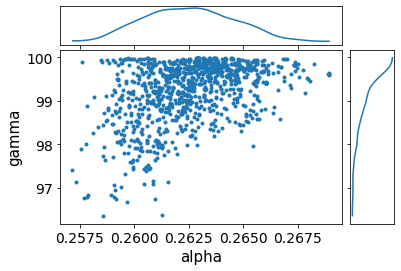

In [148]:
az.plot_pair(gal_trace, var_names=['alpha','gamma'], marginals=True)